# Digit Recognizer

In [105]:
# read the data and preprocess it with CNN
import pandas as pd

raw_test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
raw_train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [106]:
raw_test_df.shape, raw_train_df.shape

((28000, 784), (42000, 785))

In [107]:
train_label = raw_train_df['label'].values
train_label.shape

(42000,)

In [108]:
train_rows = raw_train_df.drop(columns='label').values
train_rows.shape

(42000, 784)

In [109]:
# reshape
import numpy as np

train_X = train_rows.reshape(train_rows.shape[0], int(np.sqrt(train_rows.shape[1])) , -1)
train_X.shape

(42000, 28, 28)

In [110]:
test_rows = raw_test_df.values
test_X = test_rows.reshape(-1, 28, 28)
test_X.shape

(28000, 28, 28)

In [111]:
# one hot label
train_y = pd.get_dummies(train_label.astype(str))
train_y.values

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

## Model Definition

In [112]:
# dataset
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class DigitDataset(Dataset):
    def __init__(self, path, label=True, train=True, size=None):
        super(DigitDataset, self).__init__()
        self.label = label
        raw_df = pd.read_csv(path)
        if label:
            total_y = pd.get_dummies(raw_df['label'].astype(str)).values
            total_X = raw_df.drop(columns='label').values.reshape(-1, 28, 28)
            if train:
                count = int(size * total_X.shape[0])
                self.X = total_X[:count]
                self.y = total_y[:count]
            else: # valid
                count = int(size * total_X.shape[0])
                self.X = total_X[-count:]
                self.y = total_y[-count:]
                
        else:
            self.X = raw_df.values.reshape(-1, 28, 28)
        
    def __getitem__(self, index):
        if self.label:
            return torch.tensor(self.X[index], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[index], dtype=torch.float32)
        else:
            return torch.tensor(self.X[index], dtype=torch.float32).unsqueeze(0), torch.tensor(0)
        
    def __len__(self):
        return self.X.shape[0]

In [113]:
# train one epoch without kfold
# train and valid one epoch, use kfold inside

def train_epoch(i, net, loss_func, optimizer, train_loader):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    train_loss_list = []
    train_acc_list = []

    # train 
    net.train()
    train_loss_sum = 0.0
    train_correct_sum = 0.0
    train_total = 0.0

    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        outputs = net(x)
        loss = loss_func(outputs, y)

        # backward
        loss.backward()
        optimizer.step()

        # acc
        preds = torch.argmax(outputs, dim=1)
        truths = torch.argmax(y, dim=1)
        correct_count = (preds == truths).sum().item()

        train_loss_sum += loss.item()
        train_correct_sum += correct_count
        train_total += x.shape[0]
            
        
    # print result
    train_acc = train_correct_sum / train_total
    train_loss = train_loss_sum / len(train_loader)
        
    if (i+1) % 10 == 0:
        print('Epoch {}, train accuracy: {:.2%}, train loss: {:.4f}'.format(i, train_acc, train_loss))
        
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    
    return train_loss_list, train_acc_list

In [114]:
# validate after train
def valid_epoch(i, net, loss_func, optimizer, valid_loader):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    val_loss_list = []
    val_acc_list = []
    
    # validate
    net.eval()
    val_loss_sum = 0.0
    val_correct_sum = 0.0
    val_total = 0.0

    for step, (x, y) in enumerate(valid_loader):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            outputs = net(x)
            loss = loss_func(outputs, y)

            preds = torch.argmax(outputs, dim=1)
            truths = torch.argmax(y, dim=1)
            correct_count = (preds == truths).sum().item()

            val_loss_sum += loss.item()
            val_correct_sum += correct_count
            val_total += x.shape[0]
            
    val_acc = val_correct_sum / val_total
    val_loss = val_loss_sum / len(valid_loader)
    
    if (i+1) % 10 == 0:
        print('Epoch {}, val accuracy: {:.2%}, val loss: {:.4f}'.format(i, val_acc, val_loss))
              
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)    
    
    return val_loss_list, val_acc_list

In [115]:
# plot the results
%matplotlib inline
import matplotlib.pyplot as plt

def figure(train_loss, train_acc, val_loss, val_acc):
    steps = range(len(train_loss))
    plt.figure(figsize=(16,8))
    
    plt.subplot(1,2,1)
    plt.plot(steps, train_loss, color='r', label='train loss')
    plt.plot(steps, val_loss, color='b', label='val loss')
    
    # set title
    plt.title('loss')
    plt.xlabel('steps')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(steps, train_acc, color='r', label='train acc')
    plt.plot(steps, val_acc, color='b', label='val acc')
    
    # set title
    plt.title('acc')
    plt.xlabel('steps')
    plt.legend()
    
    plt.show()

In [116]:
from torch.optim import Adam

def train(net, epochs=10, lr=0.001, batch_size=64, wd=1e-6):
    optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
    loss_func = nn.CrossEntropyLoss()
    
    train_set = DigitDataset('/kaggle/input/digit-recognizer/train.csv', label=True, train=True, size=0.8)
    valid_set = DigitDataset('/kaggle/input/digit-recognizer/train.csv', label=True, train=False, size=0.2)
        
    print('total samples: train set {}, valid set {}'.format(len(train_set), len(valid_set)))
    
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)
    
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    
    for i in range(1, 1 + epochs):
        tl, ta = train_epoch(i, net, loss_func, optimizer, train_loader)
        vl, va = valid_epoch(i, net, loss_func, optimizer, valid_loader)
        
        train_loss_list.extend(tl)
        train_acc_list.extend(ta)
        val_loss_list.extend(vl)
        val_acc_list.extend(va)
        
    # plot
    figure(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [117]:
# CNN model
import torch.nn as nn

class DigitCNN(nn.Module):
    def __init__(self, output_size):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fc1 = nn.Linear(2 * 2 * 64, 64)
        self.output = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x.reshape(x.shape[0], -1))
        x = self.output(x)
        return x

In [118]:
net = DigitCNN(10)

total samples: train set 33600, valid set 8400
Epoch 9, train accuracy: 99.77%, train loss: 0.0079
Epoch 9, val accuracy: 98.67%, val loss: 0.0486


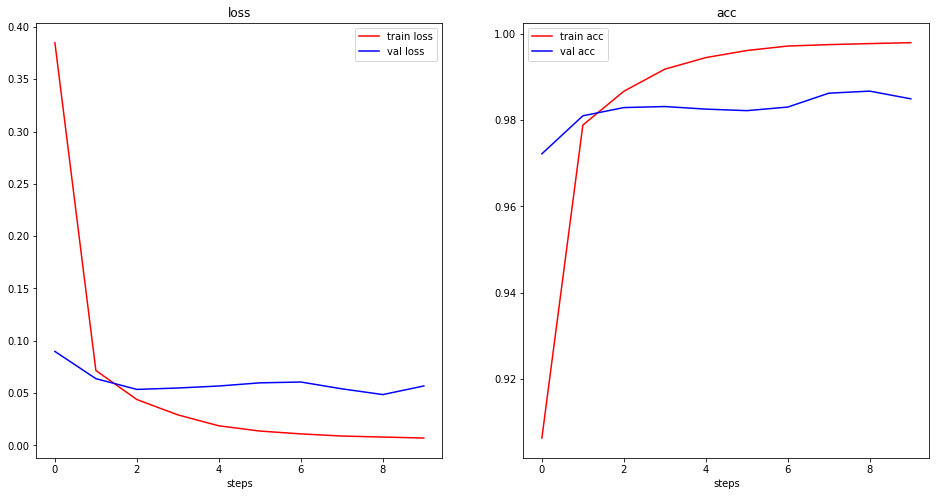

In [119]:
import torch

train(net, epochs=10, batch_size=256, wd=1e-6, lr=0.001)

In [121]:
# make submission
commit = pd.DataFrame()
commit['ImageId'] = range(1, raw_test_df.shape[0] + 1)

In [123]:
# submission
preds = []
test_set = DigitDataset('/kaggle/input/digit-recognizer/test.csv', label=False, train=False)
test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=64)

for i, (data, _) in enumerate(test_loader):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net.eval()
    with torch.no_grad(): 
        data = data.to(device)
        outs = net(data)
        pred = torch.argmax(outs, dim=1)
        preds.extend(pred.tolist())

len(preds)


28000

In [125]:
commit['Label'] = preds

In [126]:
commit

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [127]:
commit.to_csv('submission.csv',index=False)